In [7]:
import warnings
import pandas as pd
from Methods1 import *
import time
import os
import kittiwrapper,util
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:

def plot_training_error(loss, loss1, bloss):
    # Create a new figure and set the title
    fig, ax = plt.subplots()
    ax.set_title('Training Error')

    # Plot the three loss curves on the same axis
    ax.plot(loss, label='Reconstruction Loss')
    ax.plot(loss1, label='Latent Space Loss')
    ax.plot(bloss, label='Overall Loss')

    # Set the axis labels and legend
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    
    # Show the plot
    plt.show()


In [4]:
file='/home/anas/Desktop/PHD/my essai/Kitti dataset/City' #[long (2011_10_03,27) ,Residence, Campus-8, Person-8, Road, City]
seque = ['00','05','06','07','08','09','10']
seq = 13
date =['2011_10_03', '2011_09_30', '2011_09_30', '2011_09_30', '2011_09_30','2011_09_30', '2011_09_30']
drive=['0027', '0018','0020', '0027', '0028', '0033', '0034']
date1 = ['2013-04-05','2013-01-10', '2012-12-01', '2012-01-08', '2012-06-15', '2012-04-29', '2012-02-04']

In [9]:
all_features = []
real_poses = []
i=0
for ele in tqdm(date1):
    if(i == 0):
        features, T_w_r_gt = features_extraction_NCLT(ele, model = 'fkm' ,nodes_number = 5, var = -0.5)
        all_features.append(features)
        T_w_r_gt = util.ht2xyp(T_w_r_gt)
        T_w_r_gt = T_w_r_gt[:,:2]
        real_poses.append(T_w_r_gt)
        i=10
    else:
        features, T_w_r_gt = features_extraction_NCLT(ele, model = 'fkm' ,nodes_number = 5, var = -0.9)
        all_features.append(features)
        T_w_r_gt = util.ht2xyp(T_w_r_gt)
        T_w_r_gt = T_w_r_gt[:,:2]
        real_poses.append(T_w_r_gt)
'''for i in range(len(date)):
    sequence ,T_w_velo, T_w_velo_gt = handling_data(os.path.join(file,seque[i]),seq,date[i],drive[i])
    T_w_velo_gt = util.ht2xyp(T_w_velo_gt)
    T_w_velo_gt = T_w_velo_gt[:,:2]
    n = len(sequence.poses)
    features = features_extraction_Kitti(n,sequence,T_w_velo,5,'fkm')
    all_features.append(features)
    real_poses.append(T_w_velo_gt)'''

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20901 [00:00<?, ?it/s]

  0%|          | 0/5120 [00:00<?, ?it/s]

  0%|          | 0/23016 [00:00<?, ?it/s]

  0%|          | 0/28127 [00:00<?, ?it/s]

  0%|          | 0/16545 [00:00<?, ?it/s]

  0%|          | 0/12971 [00:00<?, ?it/s]

  0%|          | 0/23506 [00:00<?, ?it/s]

"for i in range(len(date)):\n    sequence ,T_w_velo, T_w_velo_gt = handling_data(os.path.join(file,seque[i]),seq,date[i],drive[i])\n    T_w_velo_gt = util.ht2xyp(T_w_velo_gt)\n    T_w_velo_gt = T_w_velo_gt[:,:2]\n    n = len(sequence.poses)\n    features = features_extraction_Kitti(n,sequence,T_w_velo,5,'fkm')\n    all_features.append(features)\n    real_poses.append(T_w_velo_gt)"

In [10]:
k = []
for ele in all_features:
    k.append(np.vstack(ele))
data = np.concatenate(np.asarray(k))
data = data.reshape((int(data.shape[0]/5),5,3))
data1 = np.mean(data[:], axis = 1)
data2 = np.concatenate((data, np.expand_dims(data1 , axis=1)), axis=1)
truth = prelimination(np.asarray(real_poses).shape[0],np.asarray(real_poses))

/tmp/ipykernel_4320/1615842482.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.concatenate(np.asarray(k))
/tmp/ipykernel_4320/1615842482.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  truth = prelimination(np.asarray(real_poses).shape[0],np.asarray(real_poses))


  0%|          | 0/7 [00:00<?, ?it/s]

# Autoencoder

## Def :
An autoencoder is a neural network that is trained to reconstruct its inputs. It consists of two parts: an encoder, which maps the input data to a hidden representation, and a decoder, which maps the hidden representation back to the original data space. Autoencoders can be used for dimensionality reduction, feature learning, and denoising, among other tasks.

## Sparsity:
One way to modify an autoencoder is to add sparsity constraints, which encourage the hidden representation to have a low number of non-zero elements. This can be achieved by adding an additional term to the loss function that penalizes the number of non-zero elements in the hidden representation.

## Diversity:
To add diversity constraints to the autoencoder, you can encourage the hidden representation to be as different as possible from one another. This can be achieved by adding an additional term to the loss function that measures the similarity between hidden representations. For example, you could use the L2 distance between hidden representations as a measure of their similarity.

In [57]:
features1s = np.transpose(data2,axes=(0,2,1))[:,:2,:]
features1s = torch.from_numpy(features1s).float()

In [58]:
T_w_velo_gt1s = np.expand_dims(truth, axis = -1)
T_w_velo_gt1s = torch.from_numpy(T_w_velo_gt1s).float()

In [59]:
# Create the autoencoder model
input_size = 6
hidden_size = 1

In [60]:

class SparsediversityAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_weight=1e-4, diversity_weight=1e-4):
        super(SparsediversityAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.sparsity_weight = sparsity_weight
        self.diversity_weight = diversity_weight

    def forward(self, x):
        # Encode the input data
        encoded = self.encoder(x)
        # Compute the sparsity and diversity penalty
        sparsity_penalty = self.sparsity_weight * torch.sum(encoded != 0)
        diversity_penalty = self.diversity_weight * torch.mean(torch.norm(encoded, dim=1))
        # Decode the hidden representation
        decoded = self.decoder(encoded)
        return encoded, decoded, sparsity_penalty, diversity_penalty

In [67]:
from bayes_opt import BayesianOptimization
from skopt import gp_minimize
import random

In [98]:


# Define your objective function
def objective_function(alpha):
    #model
    model = SparsediversityAutoencoder(input_size, hidden_size, 1, 1)
    model = model.float()

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    b=[]
    l=[]
    l1=[]
    # Train the model
    for epoch in range(3000):
        # Forward pass
        #random_features1s = np.array(random.sample(features1s.tolist(), 1000))
        #random_features1s = torch.from_numpy(random_features1s).float()
        
        #random_T_w_velo_gt1s = np.array(random.sample(T_w_velo_gt1s.tolist(), 1000))
        #random_T_w_velo_gt1s = torch.from_numpy(random_T_w_velo_gt1s).float()
        #print(random_T_w_velo_gt1s.shape)
        encoded, outputs, sparsity_penalty, diversity_penalty = model(features1s)
        loss = criterion(outputs, features1s)#  + diversity_penalty + sparsity_penalty
        loss1 = criterion(encoded, T_w_velo_gt1s)
        Bloss = alpha*loss +(1-alpha)*loss1 
        #if(epoch%100==0):
        #    print(f'Epoch {epoch}: Loss {Bloss.item():.4f}')
        #    print(f'Epoch {epoch}: Loss {loss.item():.4f}')
        #    print(f'Epoch {epoch}: Loss {loss1.item():.4f}')
        #    print('----------------------------------')
        b.append(Bloss.detach().numpy())
        l.append(loss.detach().numpy())
        l1.append(loss1.detach().numpy())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        loss1.backward(retain_graph=True)
        Bloss.backward()
        optimizer.step()
    return -Bloss.item()  # Negative since BayesianOptimization aims to maximize

# Define the search space (range of alpha values to explore)
alpha_bounds = (0, 0.5)  # Example bounds for alpha values

# Set up the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds={'alpha': alpha_bounds},
    random_state=42,
    allow_duplicate_points=True
)

# Run the optimization loop
optimizer.maximize(
    init_points=15,  # Number of randomly chosen points to start with
    n_iter=30,      # Number of iterations to perform
)

# Retrieve the best alpha value and the corresponding maximum performance metric
best_alpha = optimizer.max['params']['alpha']
best_metric = -optimizer.max['target']  # Convert back to positive value

print(f"Best alpha: {best_alpha:.4f}")
print(f"Best metric: {best_metric:.4f}")


|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -2.259    | 0.1873    |
| 2         | -2.645    | 0.4754    |
| 3         | -2.008    | 0.366     |
| 4         | -1.933    | 0.2993    |
| 5         | -1.496    | 0.07801   |
| 6         | -1.178    | 0.078     |
| 7         | -1.11     | 0.02904   |
| 8         | -2.723    | 0.4331    |
| 9         | -1.816    | 0.3006    |
| 10        | -2.613    | 0.354     |
| 11        | -0.9263   | 0.01029   |
| 12        | -2.535    | 0.485     |
| 13        | -2.212    | 0.4162    |
| 14        | -1.327    | 0.1062    |
| 15        | -1.702    | 0.09091   |
| 16        | -1.354    | 0.02908   |
| 17        | -1.861    | 0.01026   |
| 18        | -2.112    | 0.01031   |
| 19        | -1.629    | 0.07798   |
| 20        | -1.887    | 0.1062    |
| 21        | -1.516    | 0.02912   |
| 22        | -1.142    | 0.07803   |
| 23        | -1.124    | 0.02914   |
| 24        | -2.062    | 0.01028   |
| 25        

In [99]:
target = []
alphaa = []
for element in optimizer.res:
    target.append(-element['target'])
    alphaa.append(element['params']['alpha'])

Text(0.5, 0, 'alpha value')

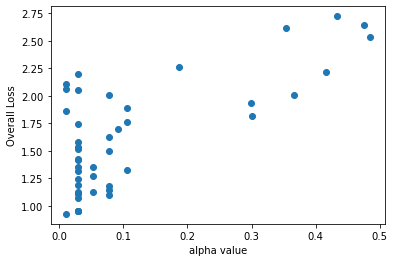

In [100]:
plt.scatter(alphaa,target)
plt.ylabel('Overall Loss')
plt.xlabel('alpha value')

In [102]:
#model
model = SparsediversityAutoencoder(input_size, hidden_size, 1, 1)
model = model.float()

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

b=[]
l=[]
l1=[]
alpha = 0.01
# Train the model
for epoch in range(3000):
    # Forward pass
    encoded, outputs, sparsity_penalty, diversity_penalty = model(features1s)
    loss = criterion(outputs, features1s)#  + diversity_penalty + sparsity_penalty
    loss1 = criterion(encoded, T_w_velo_gt1s)
    Bloss = alpha*loss +(1-alpha)*loss1 
    if(epoch%100==0):
        print(f'Epoch {epoch}: Loss {Bloss.item():.4f}')
        print(f'Epoch {epoch}: Loss {loss.item():.4f}')
        print(f'Epoch {epoch}: Loss {loss1.item():.4f}')
        print('----------------------------------')
    b.append(Bloss.detach().numpy())
    l.append(loss.detach().numpy())
    l1.append(loss1.detach().numpy())
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    loss1.backward(retain_graph=True)
    Bloss.backward()
    optimizer.step()

Epoch 0: Loss 33.6200
Epoch 0: Loss 267.9672
Epoch 0: Loss 31.2529
----------------------------------
Epoch 100: Loss 3.9600
Epoch 100: Loss 239.0862
Epoch 100: Loss 1.5849
----------------------------------
Epoch 200: Loss 3.7448
Epoch 200: Loss 218.8895
Epoch 200: Loss 1.5717
----------------------------------
Epoch 300: Loss 3.5234
Epoch 300: Loss 198.6152
Epoch 300: Loss 1.5528
----------------------------------
Epoch 400: Loss 3.3009
Epoch 400: Loss 178.3275
Epoch 400: Loss 1.5330
----------------------------------
Epoch 500: Loss 3.1028
Epoch 500: Loss 161.3513
Epoch 500: Loss 1.5043
----------------------------------
Epoch 600: Loss 2.9111
Epoch 600: Loss 145.0722
Epoch 600: Loss 1.4752
----------------------------------
Epoch 700: Loss 2.7185
Epoch 700: Loss 128.7788
Epoch 700: Loss 1.4452
----------------------------------
Epoch 800: Loss 2.5249
Epoch 800: Loss 112.4750
Epoch 800: Loss 1.4143
----------------------------------
Epoch 900: Loss 2.3306
Epoch 900: Loss 96.1649
Epo

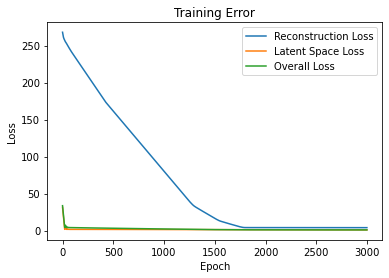

In [103]:
plot_training_error(l, l1, b)

In [198]:
sequence ,T_w_velo, T_w_velo_gt = handling_data(os.path.join(file,seque[4]),seq,date[4],drive[4])
T_w_velo_gt = util.ht2xyp(T_w_velo_gt)
T_w_velo_gt = T_w_velo_gt[:,:2]
n = len(sequence.poses)
features = features_extraction_Kitti(n,sequence,T_w_velo,5,'fkm')

  0%|          | 0/5177 [00:00<?, ?it/s]

In [104]:
file1='/home/anas/Desktop/PHD/my essai/Kitti dataset/City/KITTI2' #[Residence, Campus-8, Person-8, Road, City]
seq = 13
datee ='2011_09_26'
drivee='0009'

In [105]:
sequence ,T_w_velo, T_w_velo_gt = handling_data(file1,seq,datee,drivee)
T_w_velo_gt = util.ht2xyp(T_w_velo_gt)
T_w_velo_gt = T_w_velo_gt[:,:2]
n = len(sequence.poses)-4
features = features_extraction_Kitti(n,sequence,T_w_velo,5,'fkm')

  0%|          | 0/443 [00:00<?, ?it/s]

In [106]:
features1 = np.mean(features[:], axis = 1)
features = np.concatenate((features, np.expand_dims(features1 , axis=1)), axis=1)

In [107]:
features = np.transpose(features,axes=(0,2,1))[:,:2,:]
features = torch.from_numpy(features).float()
T_w_velo_gt = np.expand_dims(T_w_velo_gt, axis = -1)
T_w_velo_gt = torch.from_numpy(T_w_velo_gt).float()

In [108]:
# Put the model in evaluation mode
model.eval()

# Make a prediction for the given inputs
with torch.no_grad():
    outputs = model.encoder(features)

# Convert the outputs tensor to a numpy array for further processing
predictions = outputs.detach().numpy()


In [109]:
criterion(outputs,T_w_velo_gt[:n]).item()

0.5404165387153625

In [110]:
F.l1_loss(outputs,T_w_velo_gt[:n]).item()

0.5404165387153625

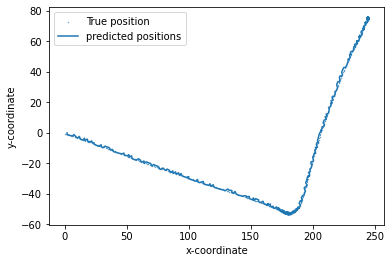

In [111]:
plt.scatter(T_w_velo_gt.detach().numpy().squeeze()[:,0], T_w_velo_gt.detach().numpy().squeeze()[:,1],0.1)
plt.plot(outputs.detach().numpy().squeeze()[:,0], outputs.detach().numpy().squeeze()[:,1],0.1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend(['True position', 'predicted positions'])